<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# NN y CNN

## Introducción

Este notebook tiene el objetivo de implementar un modelo de clasificación de cultivos mediante imágenes satelitales proporcionada por el satélite Sentinel-2. La estrategia utilizada se basa en el [paper](http://cs229.stanford.edu/proj2017/final-reports/5243811.pdf), sugerido por Rose M. Rustowicz.

A modo de resumen, el paper plantea la siguiente estrategia: Debido a las cada vez mayor cantidad de empresas aeroespaciales que proporcionan imágenes ***diarias*** con una resolución espacial relativamente alta, permiten incorporar al análisis de imágenes satelitales, ***información temporal***. Teniendo en cuenta que para algunas clases de cobertura terrestre, como los cultivos, muestran que las propiedades de la cubierta terrestre cambian con el tiempo, es decir los tipos de cultivos tienen ciclos de crecimiento, la temporalidad puede ser crucial para cuando nos enfrentamos a problemas de clasificación de cultvios.

Por lo tanto, teniendo en cuenta lo descripto anteriormente, en éste notebook implemento dos tipos de modelos, a partir de los datos multi-spectrales y multi-temporales de los cultivos. Aclarar que en éste método no se tiene encuenta ningún otro preprocesamiento de datos, cómo es el cálculo de índices de vegetación, etc:

- Red Neuronal (NN).
- Red neuronal convolucional (CNN).

Para el desarrollo de éste notebook, he creado un entorno en Anaconda con las siguientes carcaterísticas:

- dependencies:
    - keras
    - scikit-learn==0.21.2
    - imbalanced-learn

In [1]:
# Import NumPy for some statistics
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix, precision_score, recall_score,balanced_accuracy_score,accuracy_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score,classification_report, f1_score
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras import initializers
import matplotlib.pyplot as plt
import collections

C:\apps\instaladores\Anaconda3\envs\pec_tcaa\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\apps\instaladores\Anaconda3\envs\pec_tcaa\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\apps\instaladores\Anaconda3\envs\pec_tcaa\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\apps\instaladores\Anaconda3\envs\pec_tcaa\l

In [2]:
df = pd.read_csv("df_complete.csv")

In [3]:
### Preprocesamiento de datos

In [4]:
#Observamos la cantidad de cultivos que tenmos por cada tipo
df['label'].value_counts()

4    2133
7    1220
2    1037
1     767
6     684
5     503
3     474
8     209
9     147
Name: label, dtype: int64

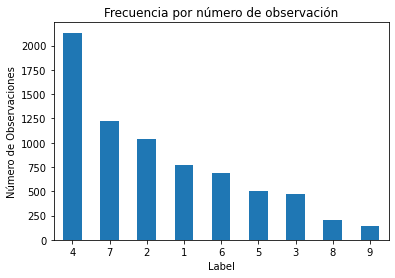

In [5]:
count_labels = pd.value_counts(df['label'], sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Frecuencia por número de observación")
plt.xlabel("Label")
plt.ylabel("Número de Observaciones");

- #### Nota:
- Se observa un cierto desbalanceo de los cultivos a estudiar.
- ***Primera opción***, se ejcutan los modelos (NN, CNN), sin tener en cuenta éste desbalanceo en las clases.
- ***Segunda opción***, se crean muestras sintéticas sólo para el cultivo minoritario (en nuestro caso el tipo 3), a través del modelo ***SMOTE***.
****PENDIENTE REVISARRRRRRRRRRRRRR****

In [6]:
#Verificamos si hay valores nulos
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [7]:
bands=['B01', 'B02', 'B03', 'B04', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
bands=['NDVI', 'SLAVI', 'MSI', 'NDRE', 'Brightness', 'Greeness', 'Wetness']
#bands=['B01', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'NDVI', 'SLAVI', 'MSI', 'NDRE','B12', 'Brightness', 'Greeness', 'Wetness']
df_tmp=df.copy()
for band in bands:
    df_tmp.drop(df_tmp.filter(regex='.'+band).columns, axis=1,inplace=True)
df=df_tmp.copy()

- #### Nota:
A continuación comenzamos a filtrar las variables que me interesan para el análisis

In [8]:
unwanted =['field_id','label']
features = list(df.columns)
features = [e for e in features if e not in unwanted]

### Preparación DataSet

Se prepara el dataset final con el cual se entrenará los modelos propuestos

In [9]:
labels = df['label']

In [10]:
data = df[features].copy()
#data = data.loc[:,data.columns.str.contains('_mean')]
#data = data.loc[:, ~data.columns.str.contains('SCL')]

In [11]:
data.shape

(7174, 456)

In [12]:
data.columns

Index(['20170401_B01', '20170411_B01', '20170421_B01', '20170501_B01',
       '20170511_B01', '20170521_B01', '20170531_B01', '20170610_B01',
       '20170620_B01', '20170630_B01',
       ...
       '20171013_B12', '20171018_B12', '20171023_B12', '20171028_B12',
       '20171102_B12', '20171107_B12', '20171112_B12', '20171117_B12',
       '20171122_B12', '20171127_B12'],
      dtype='object', length=456)

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz Confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [14]:
l_modelo=[]
l_exactitud=[]
l_bexactitud=[]
l_precision=[]
l_exhaustividad=[]
l_f1=[]
#Función que nos permite representar las métricas
def metricas_modelos(modelo,y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    #print(u'Matriz de confusión:')
    #print(cm)

    print("-----Métricas------")
    print(u'Número de muestras clasificadas correctamente:', accuracy_score(y_true, y_pred, normalize=False))
    print(u'Exactitud:', accuracy_score(y_true, y_pred))
    print("Balance Accuracy score:",balanced_accuracy_score(y_true, y_pred))
    print(u'Precision:', precision_score(y_true, y_pred,average='weighted'))
    print(u'Exhaustividad:', recall_score(y_true, y_pred,average='weighted'))
    print(u'F1:', f1_score(y_true, y_pred,average='weighted'))
    print("-------------------")
    print(classification_report(y_true, y_pred))
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=labels)
    
    l_modelo.append(modelo)
    l_exactitud.append(accuracy_score(y_true, y_pred)*100)
    l_bexactitud.append(balanced_accuracy_score(y_true, y_pred)*100)
    l_precision.append(precision_score(y_true, y_pred,average='weighted')*100)
    l_exhaustividad.append(recall_score(y_true, y_pred,average='weighted')*100)
    l_f1.append(f1_score(y_true, y_pred,average='weighted')*100)

- #### Nota:
Split de los datos con lo que voy a entrenar y testear los diferentes modelos de éste notebook, 70%: entrenamiento y 30% test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30,shuffle = True,stratify=labels)#, random_state=42

In [16]:
y_train.shape,y_test.shape

((5021,), (2153,))

#### Escalado Estándard:

Escalamos/Normalizamos el conjunto de datos antes de utilizarlos en los diferentes modelos. Es una buena práctica, para que los valores de las diferentes variables se encuentren en un mismo rango y de esta manera no influya una más que otra al momento de entrenar los modelos propuestos.
Este escalado, utiliza la media y la desviación típica para escalar y es bastante sensible en presencia de los outlier (humo/nubes) identificados. De todos modo ha sido el escalado que me ha dado mejor resultado por eso lo he seleccionado. En el método 3 propuesto, utilizaré técnicas para "suavizar" la presencia de nubes previamanete escalar. En el método actual obviaremos éste razonamiento.

In [17]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

##### Over and Undersampling

Combined used of SMOTE and ENN or Tomek Links to amplify the minority class and remove noisy observations that might be created.

In [18]:
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [19]:
from imblearn.combine import SMOTEENN, SMOTETomek
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=-1
)

# need ENN  as argument of SMOTEENN
enn = EditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=-1)

smenn = SMOTEENN(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    smote=sm,
    enn=enn,
    n_jobs=-1
)

allknn = AllKNN(sampling_strategy='auto',
        n_neighbors=5,
        kind_sel='all',
        n_jobs=-1)

#X_train, y_train = allknn.fit_resample(X_train, y_train) #under-samling
X_train, y_train = sm.fit_resample(X_train, y_train) #over-samling
#X_train, y_train = smenn.fit_resample(X_train, y_train)#over & under-samling

In [20]:
print(X_train.shape, y_train.shape)
pd.value_counts(y_train, sort = True)

(13437, 456) (13437,)


7    1493
6    1493
5    1493
4    1493
3    1493
2    1493
9    1493
1    1493
8    1493
dtype: int64

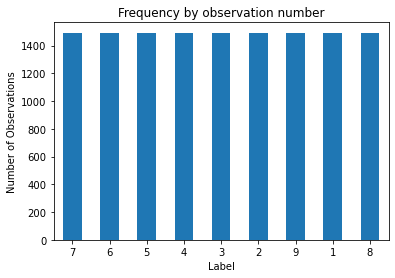

In [21]:
count_labels = pd.value_counts(y_train, sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Label")
plt.ylabel("Number of Observations");

In [22]:
#creación de variables dummy que representan las clases de cultivos: 1,2,3,4,5,6,7,8,9
n_classes=9
# encode class values as integers
encoder = LabelEncoder()

In [23]:
encoder.fit(labels.to_numpy())
encoded_Y = encoder.transform(y_train)
# Converimos valores integers a variables dummy (one hot encoded)
y_train = keras.utils.to_categorical(encoded_Y,num_classes=n_classes) #np_utils.to_categorical(encoded_Y)

In [24]:
encoder.fit(labels.to_numpy())
encoded_Y = encoder.transform(y_test)
# Converimos valores integers a variables dummy (one hot encoded)
y_test = keras.utils.to_categorical(encoded_Y,num_classes=n_classes) #np_utils.to_categorical(encoded_Y)

In [25]:
y_train.shape,y_test.shape

((13437, 9), (2153, 9))

### Red Neuronal

In [26]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

model = Sequential()
model.add(Dense(200, input_shape=(456, ), activation='relu',kernel_regularizer=regularizers.l2(1e-5),kernel_initializer=keras.initializers.glorot_normal(seed=seed),bias_initializer='zeros'))
model.add(Dropout(20))
model.add(Dense(100))
model.add(Dropout(10))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               91400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 112,409
Trainable params: 112,409
Non-trainable params: 0
_________________________________________________________________


In [27]:
sgd = keras.optimizers.Adam() #keras.optimizers.Adadelta()
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

Instructions for updating:
Use tf.cast instead.
Train on 10749 samples, validate on 2688 samples
Epoch 1/50
10749/10749 [==============================] - 1s 119us/step - loss: 1.1146 - acc: 0.6268 - val_loss: 2.0261 - val_acc: 0.3147
Epoch 2/50
10749/10749 [==============================] - 1s 104us/step - loss: 0.8274 - acc: 0.7283 - val_loss: 1.5119 - val_acc: 0.4066
Epoch 3/50
10749/10749 [==============================] - 1s 101us/step - loss: 0.7037 - acc: 0.7680 - val_loss: 2.0694 - val_acc: 0.4059
Epoch 4/50
10749/10749 [==============================] - 1s 107us/step - loss: 0.6147 - acc: 0.7974 - val_loss: 1.3614 - val_acc: 0.5082
Epoch 5/50
10749/10749 [==============================] - 1s 102us/step - loss: 0.5468 - acc: 0.8224 - val_loss: 1.3252 - val_acc: 0.6257
Epoch 6/50
10749/10749 [==============================] - 1s 119us/step - loss: 0.5094 - acc: 0.8328 - val_loss: 1.5817 - val_acc: 0.5625
Epoch 7/50
10749/10749 [==============================] - 1s 122us/step - l

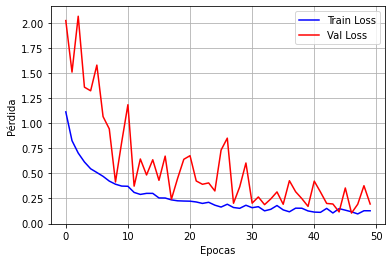

In [28]:
#Entrenar el modelo
history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=25,
         shuffle=True,validation_split=0.2,verbose=1)
score = model.evaluate(X_test, y_test, batch_size=25)
plt.xlabel('Epocas') 
plt.ylabel('Pérdida')
plt.plot(history.epoch, np.array(history.history['loss']),'b', label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), 'r', label = 'Val Loss')
plt.legend()
plt.grid()

In [29]:
#model.fit(X_train, y_train,
#          epochs=30,
#          batch_size=25,
#         shuffle=True)
#score = model.evaluate(X_test, y_test, batch_size=25)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


acc: 72.69%


In [30]:
yTestPredicted = model.predict(X_test)
prediccion = yTestPredicted.argmax(axis=1)
y_test1 = y_test.argmax(axis=1)

In [31]:
y_test1 = encoder.inverse_transform(y_test1)
prediccion = encoder.inverse_transform(prediccion)

In [32]:
y_test1.shape,prediccion.shape

((2153,), (2153,))

-----Métricas------
Número de muestras clasificadas correctamente: 1565
Exactitud: 0.7268927078495123
Balance Accuracy score: 0.6579945043797163
Precision: 0.7262784715100079
Exhaustividad: 0.7268927078495123
F1: 0.7255039473260751
-------------------
              precision    recall  f1-score   support

           1       0.60      0.58      0.59       230
           2       0.58      0.66      0.61       311
           3       0.63      0.54      0.58       142
           4       0.91      0.91      0.91       640
           5       0.66      0.60      0.63       151
           6       0.62      0.53      0.57       206
           7       0.77      0.81      0.79       366
           8       0.64      0.65      0.65        63
           9       0.62      0.64      0.63        44

    accuracy                           0.73      2153
   macro avg       0.67      0.66      0.66      2153
weighted avg       0.73      0.73      0.73      2153



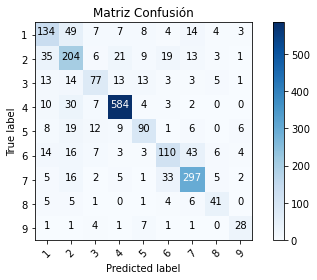

In [33]:
metricas_modelos('Simple NN, NB',y_test1, prediccion, [1,2,3,4,5,6,7,8,9])

### Red Neuronal Convolucional

In [34]:
model = Sequential()
model.add(Conv1D(kernel_size = 5, strides=1,filters = 32, activation='relu',input_shape=(456,1)))
                    
print(model.input_shape)
print(model.output_shape)

model.add(MaxPooling1D(pool_size = (2), strides=(2)))
print(model.output_shape)

model.add(Conv1D (kernel_size = 5, strides=1, filters = 64, activation='relu'))
print(model.output_shape)

model.add(MaxPooling1D(pool_size = (2), strides=(2)))
print(model.output_shape)

model.add(Flatten())

print(model.output_shape)

model.add(Dense (1000, activation='relu'))
print(model.output_shape)

model.add(Dense(n_classes, activation = 'softmax'))#,activity_regularizer=keras.regularizers.l2()))
print(model.output_shape)

#model.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.01), metrics=[keras.metrics.categorical_accuracy])
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

(None, 456, 1)
(None, 452, 32)
(None, 226, 32)
(None, 222, 64)
(None, 111, 64)
(None, 7104)
(None, 1000)
(None, 9)


In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 452, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 226, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 64)           10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 111, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7104)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              7105000   
_________________________________________________________________
dense_5 (Dense)              (None, 9)                

In [36]:
X1 = np.expand_dims(X_train, axis=2)
X1.shape,y_train.shape

((13437, 456, 1), (13437, 9))

Train on 10749 samples, validate on 2688 samples
Epoch 1/15
10749/10749 [==============================] - 71s 7ms/step - loss: 0.9866 - accuracy: 0.6668 - val_loss: 1.6163 - val_accuracy: 0.3932
Epoch 2/15
10749/10749 [==============================] - 68s 6ms/step - loss: 0.4948 - accuracy: 0.8408 - val_loss: 1.3029 - val_accuracy: 0.4836
Epoch 3/15
10749/10749 [==============================] - 70s 7ms/step - loss: 0.2586 - accuracy: 0.9235 - val_loss: 0.4832 - val_accuracy: 0.8047
Epoch 4/15
10749/10749 [==============================] - 68s 6ms/step - loss: 0.1409 - accuracy: 0.9581 - val_loss: 0.3464 - val_accuracy: 0.8828
Epoch 5/15
10749/10749 [==============================] - 68s 6ms/step - loss: 0.0932 - accuracy: 0.9715 - val_loss: 0.3187 - val_accuracy: 0.8936
Epoch 6/15
10749/10749 [==============================] - 66s 6ms/step - loss: 0.0647 - accuracy: 0.9818 - val_loss: 0.1871 - val_accuracy: 0.9431
Epoch 7/15
10749/10749 [==============================] - 68s 6ms/ste

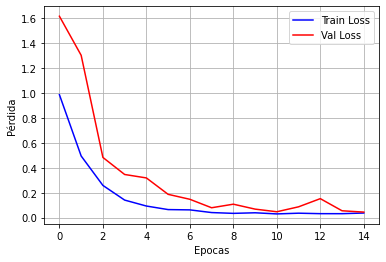

In [37]:
#model.fit(X1, y_train, epochs=15, batch_size=50)
#Entrenar el modelo
history = model.fit(X1, y_train,
          epochs=15,
          batch_size=25,
         shuffle=True,validation_split=0.2,verbose=1)
plt.xlabel('Epocas') 
plt.ylabel('Pérdida')
plt.plot(history.epoch, np.array(history.history['loss']),'b', label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), 'r', label = 'Val Loss')
plt.legend()
plt.grid()

In [38]:
X2 = np.expand_dims(X_test, axis=2)

In [39]:
yTestPredicted = model.predict(X2)
prediccion = yTestPredicted.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [40]:
y_test = encoder.inverse_transform(y_test)
prediccion = encoder.inverse_transform(prediccion)

In [41]:
y_test.shape,prediccion.shape

((2153,), (2153,))

-----Métricas------
Número de muestras clasificadas correctamente: 1545
Exactitud: 0.7176033441709243
Balance Accuracy score: 0.655181398196501
Precision: 0.7195015127093749
Exhaustividad: 0.7176033441709243
F1: 0.7166736972993573
-------------------
              precision    recall  f1-score   support

           1       0.61      0.67      0.64       230
           2       0.60      0.58      0.59       311
           3       0.67      0.53      0.59       142
           4       0.88      0.93      0.90       640
           5       0.63      0.68      0.65       151
           6       0.52      0.54      0.53       206
           7       0.81      0.72      0.76       366
           8       0.53      0.70      0.60        63
           9       0.66      0.57      0.61        44

    accuracy                           0.72      2153
   macro avg       0.66      0.66      0.65      2153
weighted avg       0.72      0.72      0.72      2153



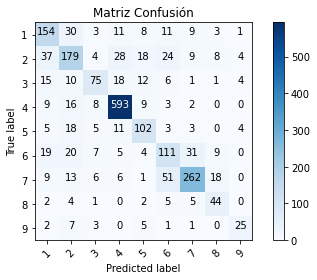

In [42]:
metricas_modelos('CNN, NB',y_test, prediccion, [1,2,3,4,5,6,7,8,9])

## Conclusión

In [43]:
resultados = pd.DataFrame({'Modelo':l_modelo,'Exactitud': l_exactitud, 'Exactitud Bal.': l_bexactitud,
             'Precisión':l_precision,'Exhaustividad': l_exhaustividad, 'F1': l_f1})

In [44]:
resultados.round(2)

,Modelo,Exactitud,Exactitud Bal.,Precisión,Exhaustividad,F1
0,"Simple NN, NB",72.69,65.80,72.63,72.69,72.55
1,"CNN, NB",71.76,65.52,71.95,71.76,71.67


Podemos concluir que los resultados obtenidos con ambos modelos y tenieno en cuenta ***solo*** la infromación espectral y temporal de las imágenes, sin tener en cuenta ínidces de vegetación se pueden considerar bastante bueno. Es parejo el resultado obtenido con ambos modelos.

Podemos decir que obtenemos de manera general mejores resultado con la Red Neuronal Simple tanto balancenado los datos o sin hacerlo.Mirando la tablas de las métricas y la tabla de confusión de cada ejecución, podemos concluir que si bien obtenemos mejores resultados cuando entrenamos con clases ***desbalanceadas***, es importante destacar que cuando ***balanceamos las clases***, en el caso de Red Neuronal Simple, para la clase minoritaria mejoran todas las métricas. En cambio para la Red Neuronal Convolucional es impercetible la mejora, inclusive podemos decir que una vez balanceados los datos de entrenamiento para la clase minoritaria, se nota una desmejora en la generalización del modelo. 